# 👩‍⚖️ ⚖️ Machine Learning Court： Recidivism Prediction - 🟦 Defense


## ⚖️ Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 Prosecution
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

#### 🟦 Defense
Argue that the decision was reasonable based on the model's criteria. Use explanation tools to show which features were most influential and whether the classification aligns with data-driven patterns.

## Load Lib

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import shap
import lime
import lime.lime_tabular
from anchor import anchor_tabular

## Load Data

In [37]:
# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# store original categorical mappings for interpretation
sex_map = {0: 'Female', 1: 'Male'}
race_categories = df['race'].unique()
race_map = {i: race for i, race in enumerate(race_categories)}
charge_map = {0: 'Misdemeanor', 1: 'Felony'}

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

              precision    recall  f1-score   support

           0       0.67      0.68      0.68       823
           1       0.57      0.56      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

In [38]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)

Prediction for Malik Johnson (Recidivism): [0]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Shap

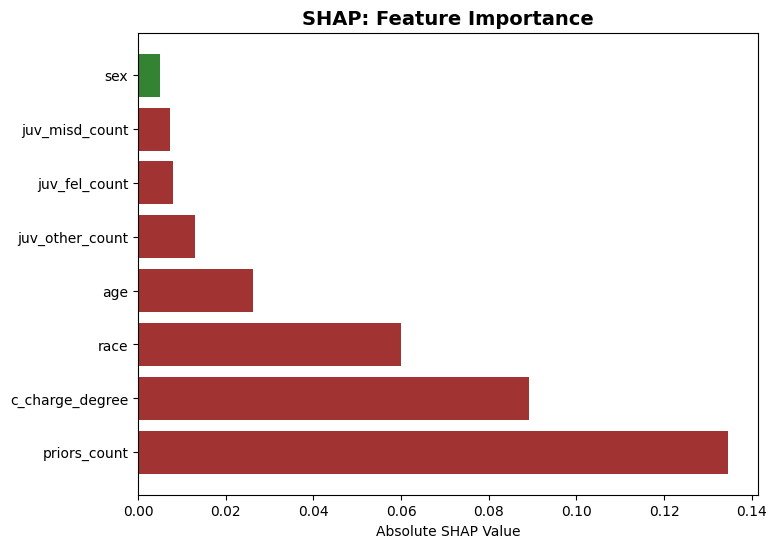

In [ ]:
# init
explainer = shap.TreeExplainer(model_compas)
shap_values = explainer.shap_values(focus_instance_compas)
values = shap_values[0]

# get feature impact
feature_impacts = []
for i, feature in enumerate(features):
    impact_val = values[i]
    impact = float(impact_val[0])
    feature_impacts.append((feature, impact))

# plot
plt.figure(figsize=(8, 6))

sorted_impacts = sorted(feature_impacts, key=lambda x: abs(x[1]), reverse=True)
features_sorted = [f[0] for f in sorted_impacts]
impacts_sorted = [f[1] for f in sorted_impacts]

colors = ['darkgreen' if x < 0 else 'darkred' for x in impacts_sorted]
bars = plt.barh(range(len(features_sorted)), [abs(x) for x in impacts_sorted], color=colors, alpha=0.8)
plt.yticks(range(len(features_sorted)), features_sorted)
plt.xlabel('Absolute SHAP Value')
plt.title("SHAP: Feature Importance", fontsize=14, fontweight='bold')

plt.show()

The SHAP feature importance plot confirms that Malik Johnson’s low-risk classification is reasonable. His only prior felony is the largest factor, but one prior is far less predictive of reoffending than multiple priors. His clean juvenile record, including zero juvenile felonies, misdemeanors, or other offenses, is a powerful protective factor, showing that he does not have a long-standing pattern of criminal behavior. While his current charge and age add modest risk, they do not make big changes.

In conclusion, the plot shows priors and charge degree as main drivers, but Malik’s case has small values for these factors and strong protective signals from his juvenile history, which justifies the parole decision.

## LIME

In [ ]:
# init lime
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=features,
    class_names=['No Recidivism', 'Recidivism'],
    mode='classification'
)

# explainer
lime_explanation = lime_explainer.explain_instance(
    focus_instance_compas.values[0], 
    model_compas.predict_proba,
    num_features=len(features)
)

# print
lime_results = lime_explanation.as_list()
print("Feature contributions to the prediction:")

lime_impacts = []
for feature_val, impact in lime_results:
    lime_impacts.append((feature_val, impact))
    print(f"{feature_val:}: {impact:.4f}")


Feature contributions to the prediction:
0.00 < priors_count <= 2.00: -0.1177
juv_fel_count <= 0.00: -0.1118
juv_misd_count <= 0.00: -0.0763
juv_other_count <= 0.00: -0.0619
25.00 < age <= 31.00: 0.0492
0.00 < c_charge_degree <= 1.00: -0.0486
0.00 < race <= 2.00: 0.0078
sex <= 1.00: 0.0000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


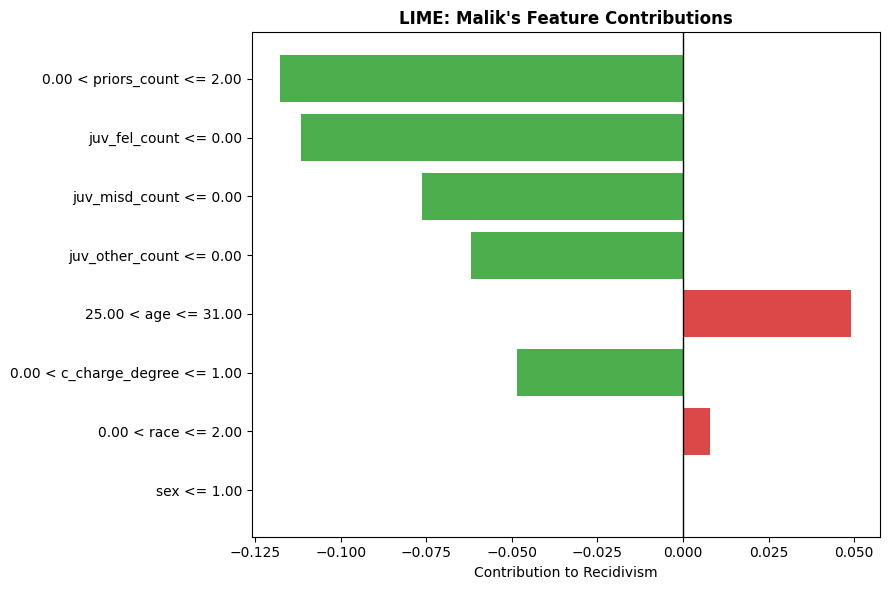

In [71]:
pairs = lime_explanation.as_list()
df = pd.DataFrame(pairs, columns=["condition", "weight"])
df["abs_weight"] = df["weight"].abs()
df = df.sort_values("abs_weight", ascending=True)

# colors mapping
colors = df["weight"].apply(lambda w: "#d62728" if w > 0 else "#2ca02c")

# plot
plt.figure(figsize=(9, 6))
bars = plt.barh(df["condition"], df["weight"], color=colors, alpha=0.85)
plt.axvline(0, color="black", lw=1)

plt.title("LIME: Malik's Feature Contributions",
          fontsize=12, fontweight="bold")
plt.xlabel("Contribution to Recidivism")
plt.tight_layout()
plt.show()

From the Lime result above, we know that positive weight pushes toward recidivism and negative weight pushes away from recidivism. For Malik's case, most influential contributions are negative, meaning they pull Malik toward no recidivism. The strongest evidence is his clean juvenile history and low prior count, which outweigh the small positive contributions from age and the tiny one from race. These support the decision to grant parole.